In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import keras
import seaborn as sns
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import np_utils
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2023-06-21 19:31:01.115018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 19:31:01.263998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-21 19:31:01.748554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/aaron/anaconda3/envs/tf/lib/
2023-06-21 19:31:01.748626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
# Hyper parameters
batch_size = 512
nb_epoch = 16

# Parameters for MNIST dataset
img_rows, img_cols = 28, 28
num_classes = 7

# Parameters for LSTM network
nb_lstm = 256
nb_time_steps = img_rows
dim_input_vector = img_cols

In [3]:
df = pd.read_csv("//home//aaron//Downloads//archive//hmnist_28_28_L.csv")
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


In [4]:
# Remove label column and normalize the images
scaler = StandardScaler()
images = scaler.fit_transform(df.drop(['label'], axis=1))

# Create a RandomOverSampler instance
oversample = RandomOverSampler()

# Apply oversampling to both images and labels
images, labels = oversample.fit_resample(images, df['label'])

# Reshape the images
images = images.reshape(-1, 28, 28)

print('Shape of images:', images.shape)

Shape of images: (46935, 28, 28)


In [5]:
#state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(images, labels, random_state=1, test_size=0.2)

# encoding labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

print('X_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X_train shape: (37548, 28, 28)
37548 train samples
9387 test samples


In [6]:
start = time.time()

In [7]:
# Define the LSTM network
model = Sequential()
model.add(LSTM(nb_lstm, input_shape=(nb_time_steps, dim_input_vector), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(nb_lstm, return_sequences=True)) 
model.add(Dropout(0.5))
model.add(LSTM(nb_lstm, return_sequences=False)) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


checkpoint_filepath = 'trained-models/lstm-best-model-L.h5'

# Define the callbacks
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=[callback_checkpoint, callback_early_stopping], validation_split=0.2)

stop = time.time()

# Evaluating the model
score = model.evaluate(x_test, y_test, verbose=0)


2023-06-21 19:31:04.245205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 19:31:04.249620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 19:31:04.249836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 19:31:04.250330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 256)           291840    
                                                                 
 dropout (Dropout)           (None, 28, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 28, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 28, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 7)                 1

2023-06-21 19:31:08.870536: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 1/59 [..............................] - ETA: 3:59 - loss: 1.9580 - accuracy: 0.1309

2023-06-21 19:31:09.629808: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


59/59 [==============================] - ETA: 0s - loss: 1.6104 - accuracy: 0.3535
Epoch 1: val_accuracy improved from -inf to 0.44767, saving model to trained-models/lstm-best-model-L.h5
59/59 [==============================] - 8s 59ms/step - loss: 1.6104 - accuracy: 0.3535 - val_loss: 1.3939 - val_accuracy: 0.4477
Epoch 2/16
59/59 [==============================] - ETA: 0s - loss: 1.2524 - accuracy: 0.5198
Epoch 2: val_accuracy improved from 0.44767 to 0.60426, saving model to trained-models/lstm-best-model-L.h5
59/59 [==============================] - 3s 46ms/step - loss: 1.2524 - accuracy: 0.5198 - val_loss: 1.0417 - val_accuracy: 0.6043
Epoch 3/16
59/59 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.6468
Epoch 3: val_accuracy improved from 0.60426 to 0.70706, saving model to trained-models/lstm-best-model-L.h5
59/59 [==============================] - 3s 46ms/step - loss: 0.9383 - accuracy: 0.6468 - val_loss: 0.7714 - val_accuracy: 0.7071
Epoch 4/16
59/59 [

In [8]:
stop = time.time()

# Evaluating the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Summary: Loss over the test dataset: %.2f,' % (score[0]))
print('Accuracy: %.2f%%' % (score[1] * 100))

Summary: Loss over the test dataset: 0.17,
Accuracy: 95.11%


In [9]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get the unique class labels
class_labels = np.unique(np.concatenate((y_true, y_pred_classes)))

# Create the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_classes, labels=class_labels)

294/294 [==============================] - 2s 6ms/step


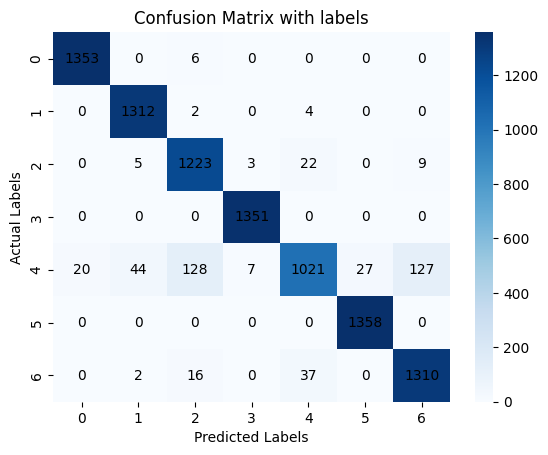

In [10]:
# Create the heatmap
ax = sns.heatmap(confusion_matrix, fmt='d', cmap='Blues')

# Set the title and labels
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.collections[0].colorbar.ax.tick_params(labelsize=10)

# Add value annotations
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{confusion_matrix[i, j]}',
                ha='center', va='center', color='black', fontsize=10)

plt.show()

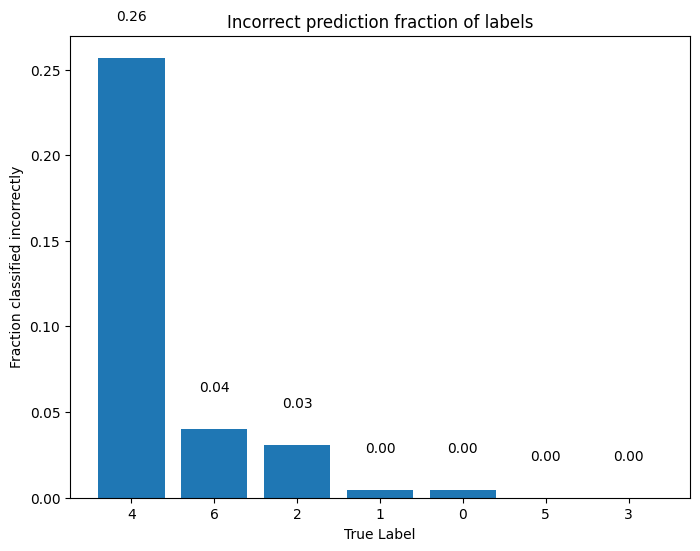

In [11]:
frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

# Sort classes based on incorrect prediction fraction
sorted_indices = np.argsort(frac_error)[::-1]
frac_error_sorted = frac_error[sorted_indices]

# Create the figure and plot
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(frac_error_sorted)), frac_error_sorted)

# Add labels to the bars
for i, frac in enumerate(frac_error_sorted):
    plt.text(i, frac + 0.02, f'{frac:.2f}', ha='center', va='bottom')

# Set the x-axis ticks and labels
plt.xticks(np.arange(len(frac_error_sorted)), sorted_indices)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.title('Incorrect prediction fraction of labels')

plt.show()
